
# Прогнозирование успешности игровых продуктов для интернет-магазина компьютерных игр

В нашем распоряжении данные интернет-магазина «Стримчик», продающего компьютерные игры. Нам доступны данные, полученные из открытых источников, о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

---

## Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns


# открываем файлы, в качестве разделителя указываем ','
try:
    df_games= pd.read_csv('/datasets/games.csv', sep=',')
except:
    df_games= pd.read_csv('games.csv', sep=',')

# устанавливаем отображение количества столбцов экране 
pd.options.display.max_columns = 40
pd.set_option('max_colwidth', 120)

#ограничим формат float 2 знаками после точки
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

Прим. <font color='brown'>для построения в дальшейшем `.relplot()` пришлось обновить версию seaborn</font>

In [2]:
#закомментили, чтобы каждый раз не пытаться обновить seaborn 
#pip install seaborn --upgrade

Получим информацию о нашей таблице методами `.info()` и `.describe()` и просмотрим первые строки нашей таблицы

In [6]:
print('')
print ('\033[1m' + 'Вывод первых строк таблицы' + '\033[0m')
display(df_games.head())

print('')
print ('\033[1m' + 'Вывод метода info()' + '\033[0m')
print('')
df_games.info()

print('')
print ('\033[1m' + 'Вывод метода describe()' + '\033[0m')
display(df_games.describe())


Вывод первых строк таблицы


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN



Вывод метода info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Вывод метода describe()


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,1980.00,0.00,0.00,0.00,0.00,13.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00
max,2016.00,41.36,28.96,10.22,10.57,98.00


##### Опишем данные нашей таблицы


    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB, определяющий возрастную категорию.


#### Вывод

Уже на этом этапе мы можем заметить **проблемы**, в таблице **есть Nan** значения в столбцах Year_of_Release, Name, Genre, Critic_Score, User_Score, Rating. Еще для удобства приведем названия **столбцов к нижнему регистру**. В типах данных также есть проблемы - нужно привести значения **года к целочисленному типу**, данные User_Score pandas посчитал как **object**, приведем к типу float. Также можно будет исправить **излишнюю битность** у float64, скорее всего будет достаточно float32. Кроме того, благодаря методу `.describe()` видим, что в датафрейме в колонках продаж по регионам имеются **значения в 0 продаж**, что скорее всего обозначает, что игра не продавалась в регионе. 

## Шаг 2. Подготовка данных

Приведём к нижнему регистру названия столбцов нашей таблицы.

In [7]:
df_games.columns = df_games.columns.str.lower()

При попытке на данном этапе заменить типы данных с object на float в столбце user_score мы выявим новую проблему. Возникнет ошибка "ValueError: could not convert string to float: 'tbd'", что означает что в наших данных есть строка со значением tbd. Давайте посмотрим на эти записи.

###### Обработка значения tbd 

In [9]:
#срез датафрейма по значениям tbd в столбце user_score
df_games[df_games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.00,Sports,3.45,2.59,0.00,0.66,nan,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.00,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011.00,Sports,1.51,1.03,0.00,0.27,nan,tbd,T
645,uDraw Studio,Wii,2010.00,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,nan,Adventure,2.15,0.18,0.00,0.07,73.00,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.00,Action,0.01,0.00,0.00,0.00,67.00,tbd,E
16697,Bust-A-Move 3000,GC,2003.00,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E
16698,Mega Brain Boost,DS,2008.00,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E
16704,Plushees,DS,2008.00,Simulation,0.01,0.00,0.00,0.00,nan,tbd,E


Всего 2376 строк со значением tbd. Аббривиатура TBD — сокращение от To Be Determined, что означает, что рейтинг на тот момент еще не был определён. Оставить эти значения мы не можем, так как это помешает производить различные операции со столбцом, а замена на среднее или медиану может исказить общую картину. Поэтому заменим данные значения на 0, что будет означать, что рейтинг отсутствует. Это не повлияет на объективность анализа, так как наверняка не существует на свете игра, которая получила рейтинг 0 (даже если это киберпанк на PS3)). А при при дальнейшем анализе, если возникнет такая необходимость, нулевые значения можно будет отбросить.

In [11]:
#заменим tbd на 0 методом replace()
df_games['user_score'] = df_games['user_score'].replace('tbd', 0)

Далее для преобразования данных нам нужно обработать значения Nan в столбце года релиза игры. Давайте посмотрим какую долю от нашего датафрейма занимают пропущенные значения.

In [26]:
print('Доля пропущенных значений составляет {:.2%}'.format(df_games['year_of_release'].isnull().sum() / len(df_games)))

Доля пропущенных значений составляет 0.00%


Около полутора процента, давайте просто удалим их.

In [13]:
df_games.dropna(subset=['year_of_release'],inplace=True)

Теперь можем приступить к преобразованию данных.

###### Преобразование данных

In [17]:
#заменим тип object на float32
df_games = df_games.astype({"user_score" :'float32'})

#используем понижающее приведение downcast метода pd.to_numeric() 
df_games['year_of_release'] = pd.to_numeric(df_games['year_of_release'], downcast='integer')


df_games[['na_sales','eu_sales','jp_sales','other_sales','critic_score']] = (
    df_games[['na_sales','eu_sales','jp_sales','other_sales','critic_score']]
    .apply(lambda x: pd.to_numeric(x, downcast='float'))
)

#проверим как изменились типы данных методом info()
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float32
 5   eu_sales         16446 non-null  float32
 6   jp_sales         16446 non-null  float32
 7   other_sales      16446 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       9839 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(6), int16(1), object(4)
memory usage: 1.0+ MB


###### Обработка пропусков

В столбце с жанром и названием игры всего две строки с пропущенными значениями, удалим эти строки.

In [19]:
df_games.dropna(subset=['name', 'genre'],inplace=True)

В столбцах с оценками крайне большое количество пропущенных значений. Нам нужно принять решение о том, каким образом их обработать.

In [24]:
#Посмотрим долю пропущенных значений
print('Доля пропущенных значений в оценках критиков составляет {:.2%}'.format(df_games['critic_score'].isnull().sum() / len(df_games)))

Доля пропущенных значений в оценках критиков составляет 51.45%


In [25]:
#Посмотрим долю пропущенных значений
print('Доля пропущенных значений в оценках пользователей составляет {:.2%}'.format(df_games['user_score'].isnull().sum() / len(df_games)))

Доля пропущенных значений в оценках пользователей составляет 40.17%


Доля пропущенных значений в столбцах рейтинга крайне велика. Идеально было б заполнить данные значения действительными величинами. Так как наш датафрейм получен из открытых источников, обратимся к сети Интернет.

В результате поиска был найден .csv файл https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings, к сожалению содержащий такие же пропуски. Зато мы теперь знаем, что данные получались с www.metacritic.com, которые на указанном ресурсе со временем обновляются и дополняются. Кроме того, понятна природа пропусков, на момент парсинга сайта отсутствовали данные о рейтинге в определенных категориях, что и привело к значениям Nan. Также в найденом дампе присутствуют значения, по которым мы сможем в случае каких-либо проблем проверить наше исследование, например в файле имеется столбец Global_Sales, со значением глобальных продаж. Поэтому для будущих исследований и актуализации данных передадим разработчикам найденный на Гитхаб скрипт для формирования дампов с Metacritic https://github.com/wtamu-cisresearch/scraper.

Но это не помогло нам в текущей ситуации, придется принять решение удалять ли данные, либо же заполнять и каким образом.

Конечно самым простым способом было б удаление данных, но тогда мы потеряем данные и из других столбцов, заполнение медианой или средним может внести путаницу, если в дальнейшем придется анализировать связь между пользовательским и рейтингом критиков. Поэтому примем решение заполнить значения 0, что будет означать, что рейтинг **не определен**, и позволит нам производить различные операции со столбцами. Кроме того это позволит более вариативно подойти к анализу данных, например, при построении гистограмм по какому-то из признаков нулевые значения можно будет отсечь. 

In [27]:
#заполним пропущенные значения нулями методом .fillna()
df_games[['rating','critic_score','user_score']] = df_games[['rating','critic_score','user_score']].fillna(0)

In [54]:
#проверим отсутствие пропусков
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     16444 non-null  float32
 9   user_score       16444 non-null  float32
 10  rating           16444 non-null  object 
 11  global_sales     16444 non-null  float32
dtypes: float32(7), int16(1), object(4)
memory usage: 1.1+ MB


Пропусков больше нет, но впоследствии не будем забывать, что в датафрейме присутствует большое количество нулевых значений.

#### Добавление суммарных продаж во всех регионах

Посчитаем суммарные продажи во всех регионах и запишем полученные значения в отдельный столбец.

In [31]:
df_games['global_sales'] = df_games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [33]:
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.00,0.00,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.00,0.00,0,31.38


## Шаг 3. Исследовательский анализ данных

#### Рассчитаем количество игр, которые выпускались в разные годы

Отбросим значения в которых отсутствует год релиза.

In [35]:
#срез df без нулевых значений года релиза
count_release = df_games.loc[df_games['year_of_release'] > 0] 

Построим график

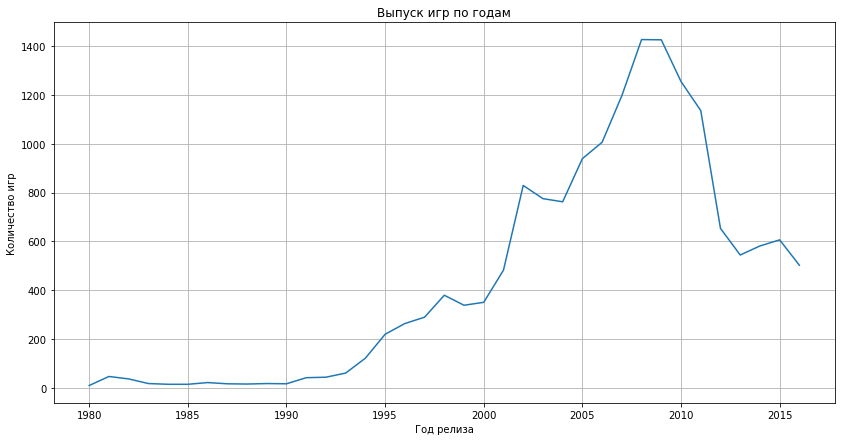

In [36]:
#сгруппируем данные по году релиза, посчитаем значения и передадим данные методу .plot()
plt.figure(figsize=(14,7))
count_release.groupby('year_of_release')['year_of_release'].count().plot()
plt.ylabel('Количество игр')   # подпишем ось У
plt.xlabel('Год релиза')   # подпишем ось У
plt.title('Выпуск игр по годам') # подпишем график
plt.grid()
plt.show()

Примерно с 1995 года можно заметить некие общие тенденции, которые примерно охватываются периодом в 5 лет. Давайте посмотрим данные последней пятилетки.

In [40]:
count_release[count_release['year_of_release'] > 2011].groupby('year_of_release')[['name']].count()

,name
year_of_release,
2012,653
2013,544
2014,581
2015,606
2016,502


Значения примерно в рамках одной тенденции. С учетом того, что рынок компьютерных игр долгое время находился в стадии становления и до сих пор является динамично меняющимся, то для прогнозирования на следующий календарный год, то будет более точным использовать ограниченный временной промежуток.

#### Распределение продаж по игровым платформам

Посмотрим, как менялись продажи по платформам в зависимости от года. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам, затем ответим на вопрос за какой характерный срок появляются новые и исчезают старые платформы.

Определим какие платформы имели наибольшие глобальные продажи.

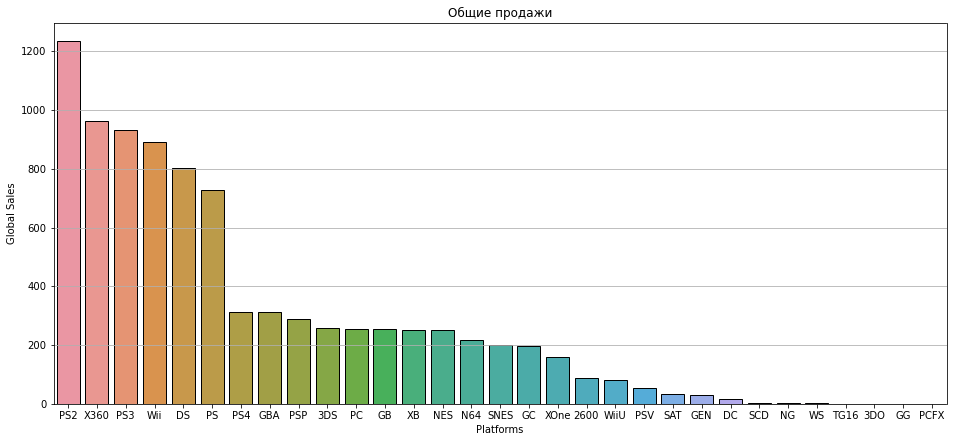

In [44]:
df_grouped = (
    df_games
    .pivot_table(index='platform', values='global_sales', aggfunc='sum')
    .sort_values(by = 'global_sales', ascending = False)
)
df_grouped = df_grouped.reset_index(drop = False) 

plt.figure(figsize=(16,7))
sns.barplot(data=df_grouped, x='platform', y='global_sales', edgecolor="black")
plt.title("Общие продажи")
plt.xlabel("Platforms")
plt.ylabel("Global Sales")
plt.grid(axis='y')
plt.show()

Посмотрим на распределение продаж топ 6 платформ.

##### Top-6 игровых платформ

In [45]:
#получим список топ 6 платформ
top6_platforms_index = df_games.groupby('platform')['global_sales'].sum().sort_values(ascending = False).head(6).index

#создадим срез со значениями по данным платформам
top6_platforms = (
    df_games
    .query('platform in @top6_platforms_index') #срез по названию столбцов из переменной top6_platforms_index
    .pivot_table(
    index=['platform','year_of_release'], 
    values='global_sales', 
    aggfunc='sum')
)

top6_platforms = top6_platforms.reset_index(drop = False) 

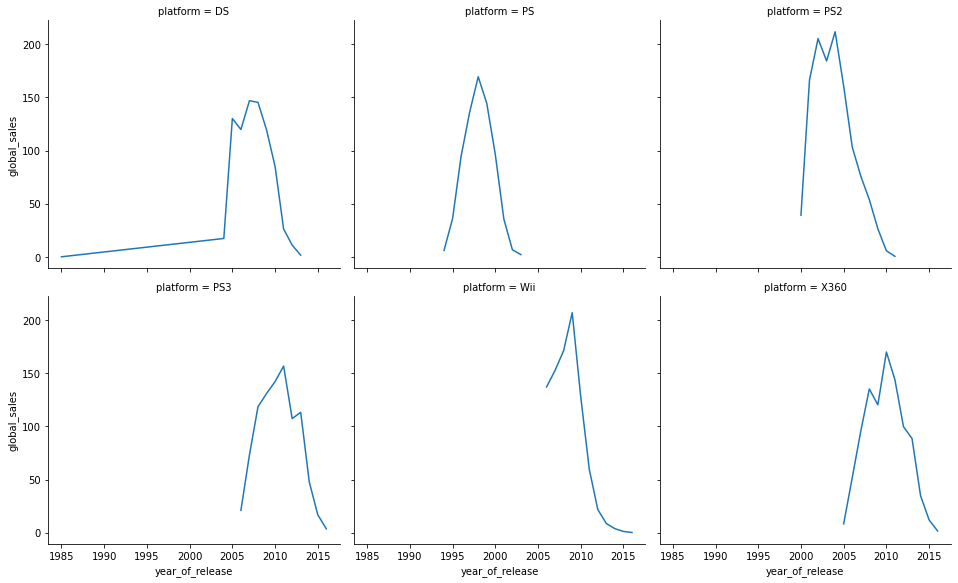

In [50]:
# для построения графика используем библиотеку seaborn 
sns.relplot(data=top6_platforms, 
            x='year_of_release', 
            col='platform', 
            y='global_sales', 
            kind='line',
            col_wrap=3,#количество графиков в строке
            height=4,
            aspect=1.1)
plt.show()

In [52]:
top6_platforms[['global_sales']].describe()

,global_sales
count,67.00
mean,82.80
std,65.06
min,0.02
25%,17.05
50%,88.58
75%,136.66
max,211.81


Если рассматривать платформы с наибольшим количеством продаж, то виден характерный срок **"жизненного цикла"** платформ, взлет и падение примерно занимает 10 лет, около **5 лет рост и затем 5 лет угасание** продаж. Также заметно, как сменяются поколения платформ на примере PS. Посмотрим на них на отдельном графике.

Кроме того, добавим к сравнению PC.

##### Серия консолей PlayStation (и PC)

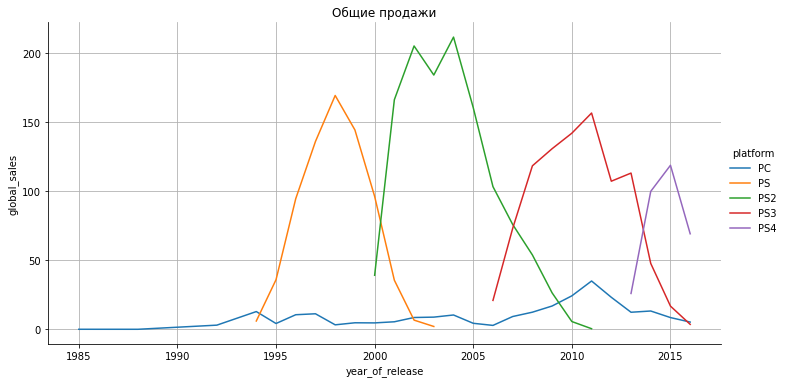

In [59]:
#сделаем срез поколений PS и сгруппируем по сумме общих продаж с разбивкой по годам
ps = (
    df_games
    .query('platform == ["PS","PS2","PS3","PS4","PC"]') #срез по PS и добавим PC
    .pivot_table(
    index=['platform','year_of_release'], 
    values='global_sales', 
    aggfunc='sum')
)

ps = ps.reset_index(drop = False) 

sns.relplot(data=ps, 
            x='year_of_release', 
            hue='platform', 
            y='global_sales', 
            kind='line',
            height=5,
            aspect=2)
plt.title("Общие продажи")
plt.grid()
plt.show()

Данные графиков по PS подтверждают **10летний срок жизни** приставки для лидеров рынка. Раннее затухание на графике платформы PS4 связано с неполными данными за 2016 год.
А PC не показывает рекордных продаж, но зато отличная стабильность.


Будет несправедливо оставить вне анализа XBox.

##### Серия консолей Xbox (и PC)

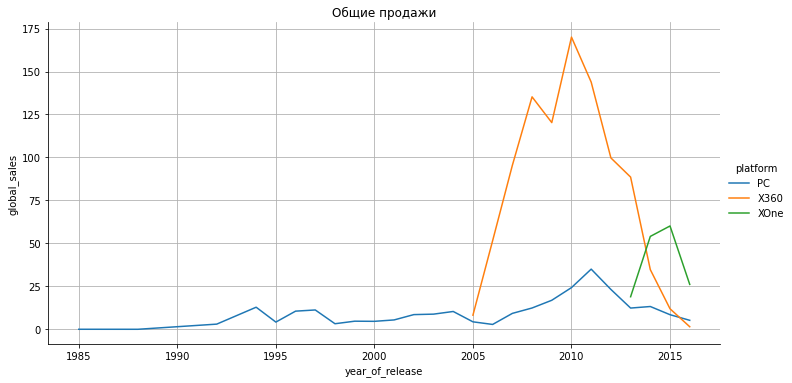

In [61]:
#сделаем срез поколений XBox и сгруппируем по сумме общих продаж с разбивкой по годам

xbox = (
    df_games
    .query('platform == ["XOne","X360", "PC"]') #срез по XBox
    .pivot_table(
    index=['platform','year_of_release'], 
    values='global_sales', 
    aggfunc='sum')
)
  
xbox = xbox.reset_index(drop = False) 

sns.relplot(data=xbox, 
            x='year_of_release', 
            hue='platform', 
            y='global_sales', 
            kind='line',
            height=5,
            aspect=2)
plt.title("Общие продажи")
plt.grid()
plt.show()

Данные графика по X360 подтверждают **10летний срок жизни** приставки для лидеров рынка. Раннее затухание на графике платформы XOne связано с неполными данными за 2016 год, а также с анонсированием в рамках выставки E3-2016 Xbox One S и выпуском её на рынок в августе 2016 года.

PC и в сравнении с Xbox сама стабильность.

### Потенциально прибыльные платформы

Основываясь на данных, полученных выше, будем считать **период 5 лет** актуальным, и основываться на нём, для прогноза на 2017 год. Исключим из анализа данные за 2016 год по причине их неполноты.

In [62]:
#Создадим соответствующий срез
actual_df =  df_games.query('2011 < year_of_release < 2016')

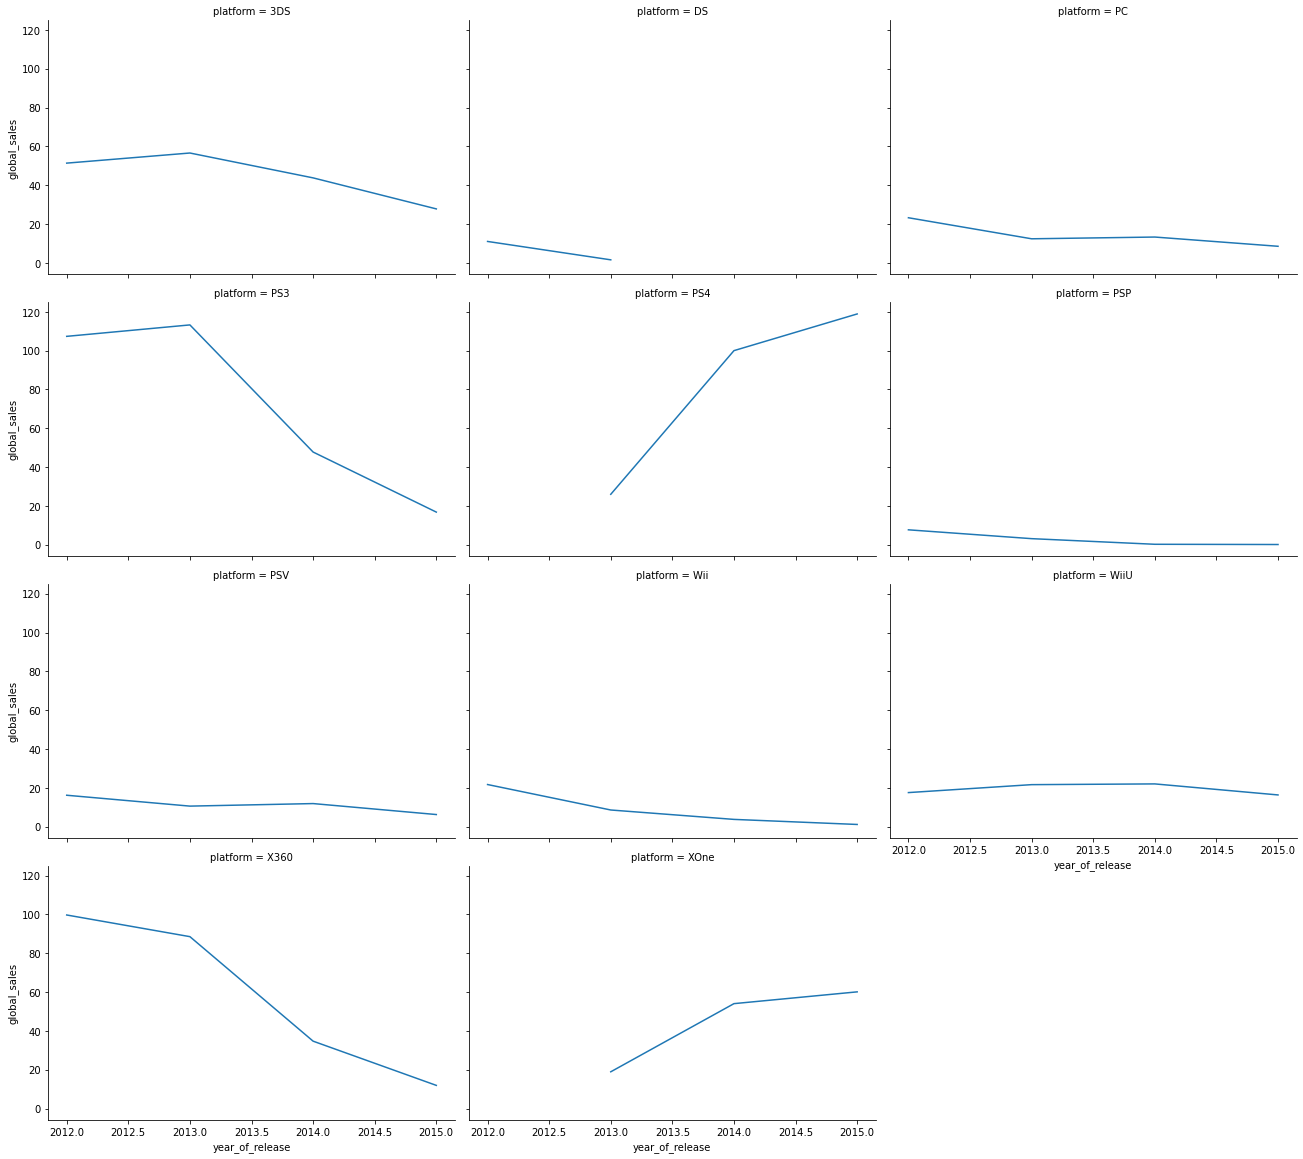

In [63]:
#сделаем группировку платформ по сумме общих продаж с разбивкой по годам
actual_platform = actual_df.pivot_table(
    index=['platform','year_of_release'], 
    values='global_sales', 
    aggfunc='sum')

actual_platform = actual_platform.reset_index(drop = False) 

# для построения графика используем библиотеку seaborn 
sns.relplot(data=actual_platform, 
            x='year_of_release', 
            col='platform', 
            y='global_sales', 
            kind='line',
            col_wrap=3,#количество графиков в строке
            height=4,
            aspect=1.5)

plt.show()

Можно заметить, что на данный момент по продажам **лидером является PS4**, также в положительной динамике продажи у Xbox One. С учетом "заката" предшествующих моделей PS3 и Xbox 360, можно утверждать, что PS4 и Xbox One являются потенциально прибыльными платформами. Ну и с учётом исторически непоколебимой стабильности, нельзя сбрасывать со счетов PC. Кроме того невысокие значения продаж по РС объясняются развитым цифровым "пиратством" на этой платформе. Остальные же платформы находятся в зоне "исторической убыли".

Посмотрим на значения общих продаж перспективных платформ.

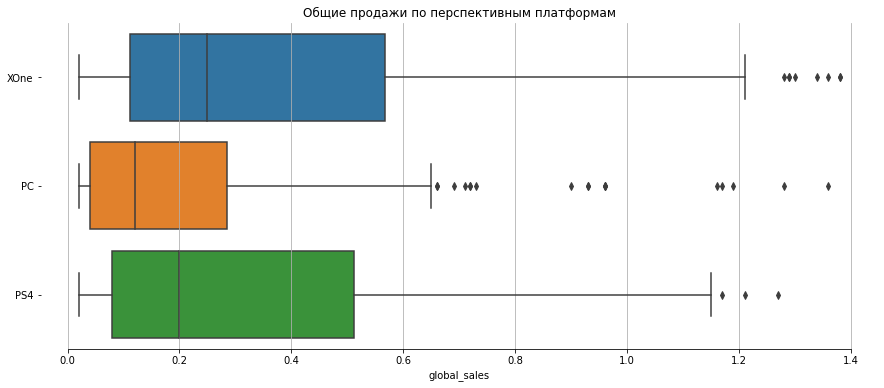

In [66]:
top_platform_list = ['PS4','XOne','PC'] #создадим список платформ
top_df = actual_df[actual_df.platform.isin(top_platform_list)] #получим нужные значения датафрейма

top_boxplot = top_df.loc[(top_df['global_sales'] >= top_df['global_sales'].quantile(.05))&(
    top_df['global_sales'] <= top_df['global_sales'].quantile(.85))]#отсечем выбросы

#постоим боксплоты
f, ax = plt.subplots(figsize=(15, 6))#установим размер
sns.boxplot(y="platform", 
            x="global_sales", 
            data=top_boxplot, 
            orient="h")
ax.xaxis.grid(True)
ax.set(ylabel="", title = "Общие продажи по перспективным платформам")
sns.despine(trim=True, left=True)

plt.show()

На боксплоте становится заметно, что **у PS4 имеются рекордные значения** по общим продажам (что мы видели с помощью метода .relplot), они присущи выбросам - более редким, но крайне успешным играм. А у X Box one значение медианы и третьего квартиля по глобальным продажам имеют бОльшие значения, поэтому **в среднем**, без учёта крайне успешных игр, для **X Box one характерны более прибыльные** продажи.

Рассчитаем среднее количество,стандартное отклонение и дисперсию

In [67]:
top_df.groupby('platform')['global_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PC,196.00,0.29,0.55,0.01,0.03,0.10,0.29,5.14
PS4,228.00,1.07,1.90,0.01,0.10,0.31,1.11,14.63
XOne,160.00,0.83,1.18,0.01,0.13,0.35,1.14,7.39


In [69]:
#дисперсия по выборке перспективных платформ
top_df.groupby('platform')[['global_sales']].var(ddof=1)

,global_sales
platform,
PC,0.30
PS4,3.61
XOne,1.40


Действительно, для PS4 характерно большее стандартное отклонение и крайне успешные игры, которые собрали большое количество продаж.

### Влияние на продажи отзывов пользователей и критиков

#### PS4

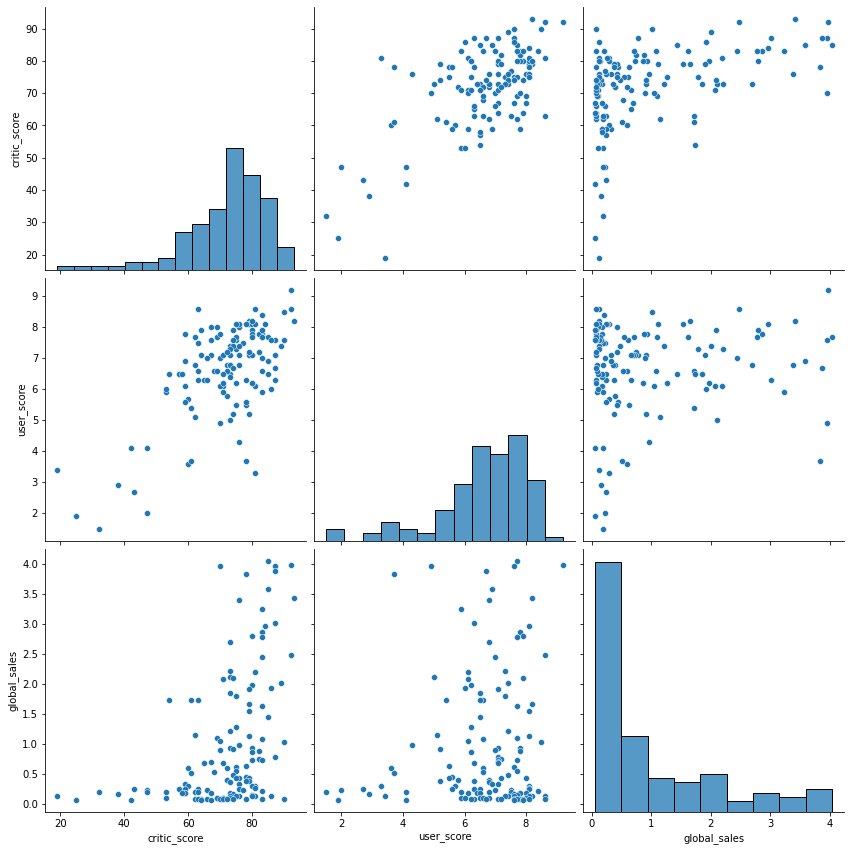

In [70]:
#исключим из выборки отзывы с оценкой 0
actual_df_drop0 = actual_df.loc[(actual_df['critic_score'] > 0) & (
    actual_df['user_score'] > 0)]

#создадим функцию для среза по платформе
def score_platform(platform):
    score = actual_df_drop0[actual_df_drop0['platform'] == platform][['critic_score', 'user_score', 'global_sales']]
    score = score.loc[(score['global_sales'] >= score['global_sales'].quantile(.10))&(
    score['global_sales'] <= score['global_sales'].quantile(.95))] #для наглядности ограничим значения  с 10 по 95 квантили
    return score

#создадим срез по платформе PS4
ps_score = score_platform('PS4')

#посмотрим сразу на все признаки 
sns_plot = sns.pairplot(ps_score, height=4)


##### Cоотношение отзывов пользователей и критиков.

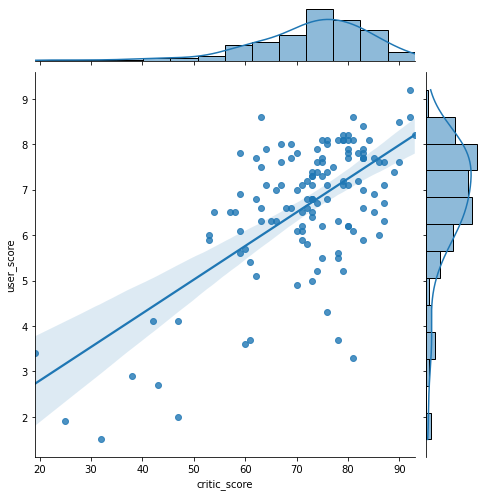

In [71]:
#построим диаграмму рассеивания оценок
sns.jointplot(data=ps_score, x='critic_score', y='user_score', kind="reg", height=7, ratio=6)

plt.show()

В общей массе довольно явно прослеживается **линейная зависимость признаков оценок** пользователей и критиков. Рассчитаем коэффициэнт корреляции и оценим его силу, чтобы убедиться в этом.

In [72]:
#Рассчитаем коэффициент Пирсона
r = ps_score['critic_score'].corr(ps_score['user_score'])
print('Коэффициэнт Пирсона оценок критиков и юзеров равен :', '{:.2f}'.format(r))

# создадим функцию для выводs силы связи по коэффициэнту Пирсона
def power_coef_r(coef_r):
    if -0.1 < r < 0.1:
        print('Коэффициэнт Пирсона в', '{:.2f}'.format(r), 
              'слишком мал мы не можем говорить о наличии какой-либо (по шкале Чеддока) связи')
    if 0.1 < r < 0.3:
        print('Коэффициэнт Пирсона в', '{:.2f}'.format(r), 
              'позволяет нам говорить о наличии слабой (по шкале Чеддока) положительной связи')
    elif 0.3 < r < 0.5:    
        print('Коэффициэнт Пирсона в', '{:.2f}'.format(r), 
              'позволяет нам говорить о наличии умеренной (по шкале Чеддока) положительной связи')        
    elif 0.5 < r < 0.7:    
        print('Коэффициэнт Пирсона в', '{:.2f}'.format(r), 
              'позволяет нам говорить о наличии заметной (по шкале Чеддока) положительной связи')
    elif 0.7 < r < 0.9:    
        print('Коэффициэнт Пирсона в', '{:.2f}'.format(r), 
              'позволяет нам говорить о наличии высокой (по шкале Чеддока) положительной связи')
        
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и юзеров равен : 0.65
Коэффициэнт Пирсона в 0.65 позволяет нам говорить о наличии заметной (по шкале Чеддока) положительной связи


##### Cоотношение отзывов пользователей и общих продаж.

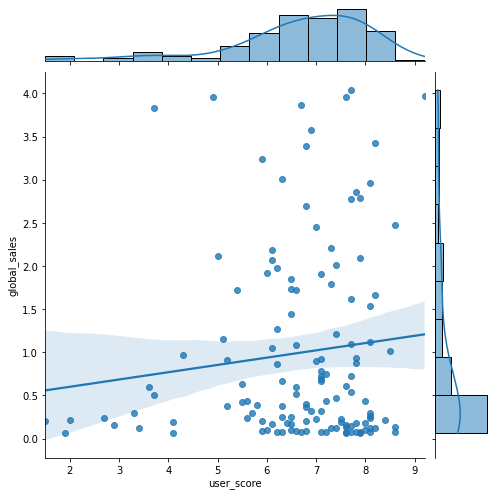

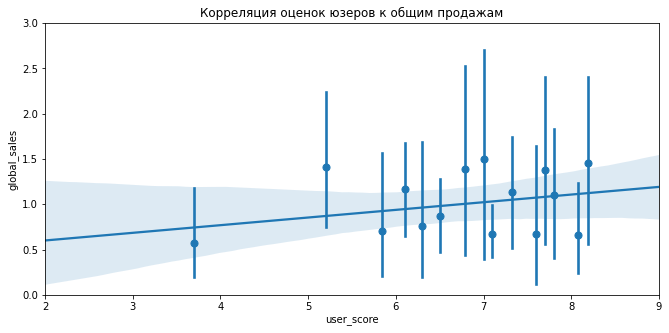

In [73]:
#построим диаграмму рассеивания продаж и оценок пользователей
sns.jointplot(data=ps_score, x='user_score', y='global_sales', kind="reg", height=7, ratio=6)
plt.show()
#посмотрим наглядно, для более типичных оценок, со значения 2 
fig, ax = plt.subplots(1,1, figsize=(11,5))
sns.regplot(x="user_score", y="global_sales", data=ps_score,
            truncate=True, x_bins=15).set(ylim=(0, 3), xlim=(2, 9))
plt.title("Корреляция оценок юзеров к общим продажам")
plt.show()

На вид если зависимость признаков оценок пользователей и продаж и есть, то она довольно неявная. Рассчитаем коэффициэнт корреляции и оценим его силу, чтобы внести ясность.

In [74]:
#Рассчитаем коэффициент Пирсона
r = ps_score['user_score'].corr(ps_score['global_sales'])
print('Коэффициэнт Пирсона оценок юзеров и общих продаж :', '{:.2f}'.format(r))
        
power_coef_r(r)

Коэффициэнт Пирсона оценок юзеров и общих продаж : 0.11
Коэффициэнт Пирсона в 0.11 позволяет нам говорить о наличии слабой (по шкале Чеддока) положительной связи


Как мы видим связь довольно **слаба**.

##### Cоотношение отзывов критиков и общих продаж.

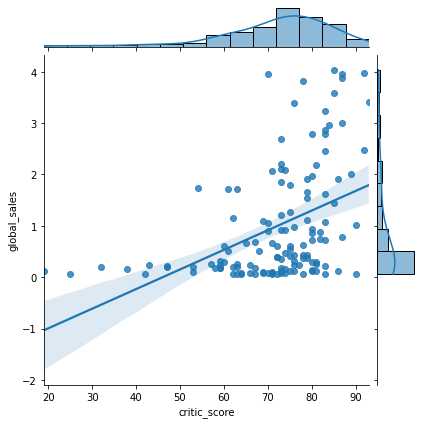

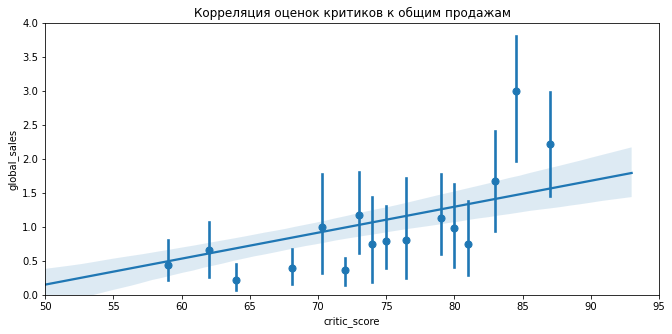

In [75]:
#построим диаграмму рассеивания продаж и оценок критиков
sns.jointplot(data=ps_score, x='critic_score', y='global_sales', kind="reg", height=6, ratio=7)
plt.show()
#посмотрим наглядно, для более типичных оценок, со значения 50 
fig, ax = plt.subplots(1,1, figsize=(11,5))
sns.regplot(x="critic_score", y="global_sales", data=ps_score,
            truncate=True, x_bins=17).set(ylim=(0, 4), xlim=(50, 95))
plt.title("Корреляция оценок критиков к общим продажам")
plt.show()

In [76]:
r = ps_score['critic_score'].corr(ps_score['global_sales'])
print('Коэффициэнт Пирсона оценок критиков и общих продаж :', '{:.2f}'.format(r))
        
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и общих продаж : 0.44
Коэффициэнт Пирсона в 0.44 позволяет нам говорить о наличии умеренной (по шкале Чеддока) положительной связи


В данном случае зависимость более **явно выражена**, чем в случае с отзывами пользователей. И сила коэффициэнта Пирсона это подтверждает.

### Отзывы и продажи для других платформ

##### X Box one

In [77]:
#создадим нужную выборку
XOne_score = score_platform('XOne')

In [79]:
# на основе предыдущего раздела создадим функцию
def sns_plot_rel(score, platform):
    print('--------------------------------------------------------------')
    print('Посмотрим сразу на все признаки платформы',platform)
    print('--------------------------------------------------------------')
    sns_plot = sns.pairplot(score, height=4)
    plt.show()
    print('--------------------------------------------------------------')
    print('')
    print('Взглянем на соотношение отзывов пользователей и критиков.')
    #построим диаграмму рассеивания оценок
    sns.jointplot(data=score, x='critic_score', y='user_score', kind="reg", height=7, ratio=6)
    plt.show()
    print('--------------------------------------------------------------')
  
    
    #построим диаграмму рассеивания продаж и оценок пользователей
    print('')
    print('Построим диаграмму рассеивания продаж и оценок пользователей',platform)
    sns.jointplot(data=score, x='user_score', y='global_sales', kind="reg", height=7, ratio=6)
    plt.show()
    #посмотрим наглядно, для более типичных оценок, со значения 2 
    print('В более наглядном представлении',platform)
    fig, ax = plt.subplots(1,1, figsize=(11,5))
    sns.regplot(x="user_score", y="global_sales", data=score,
                truncate=True, x_bins=15).set(ylim=(0, 3), xlim=(2, 9))
    plt.title("Корреляция оценок юзеров к общим продажам")
    plt.show()
    print('--------------------------------------------------------------')

    
    #построим диаграмму рассеивания общих продаж и оценок критиков
    print('')
    print('Построим диаграмму рассеивания продаж и оценок критиков',platform)
    sns.jointplot(data=score, x='critic_score', y='global_sales', kind="reg", height=6, ratio=7)
    plt.show()
    #посмотрим наглядно, для более типичных оценок, со значения 50 
    print('В более наглядном представлении',platform)
    fig, ax = plt.subplots(1,1, figsize=(11,5))
    sns.regplot(x="critic_score", y="global_sales", data=score,
                truncate=True, x_bins=17).set(ylim=(0, 4), xlim=(50, 95))
    plt.title("Корреляция оценок критиков к общим продажам")
    plt.show()
    print('--------------------------------------------------------------')


Посмотрим на распределения исследуемых признаков по платформе X Box one. 

--------------------------------------------------------------
Посмотрим сразу на все признаки платформы XOne
--------------------------------------------------------------


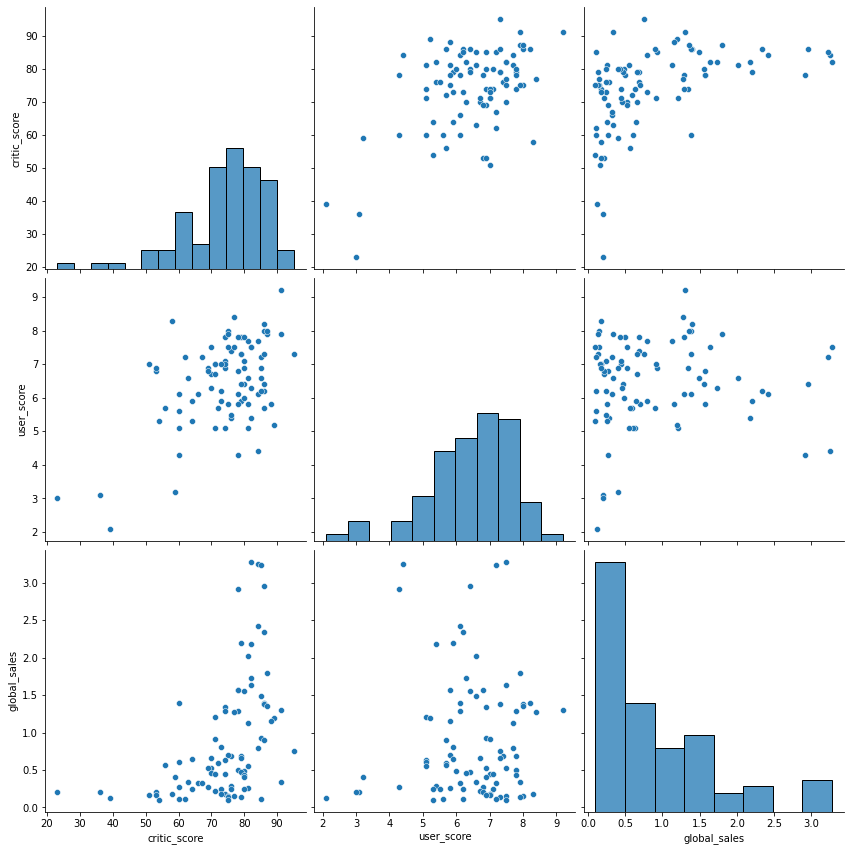

--------------------------------------------------------------

Взглянем на соотношение отзывов пользователей и критиков.


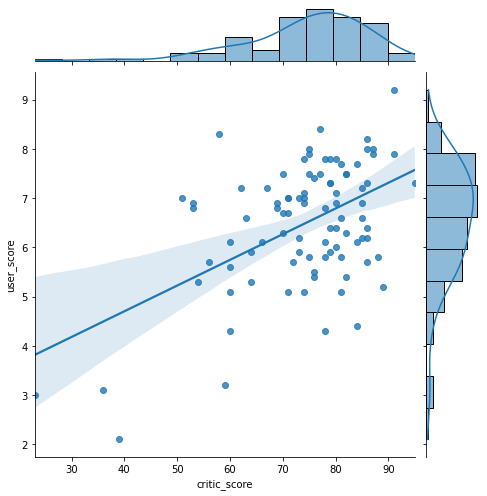

--------------------------------------------------------------

Построим диаграмму рассеивания продаж и оценок пользователей XOne


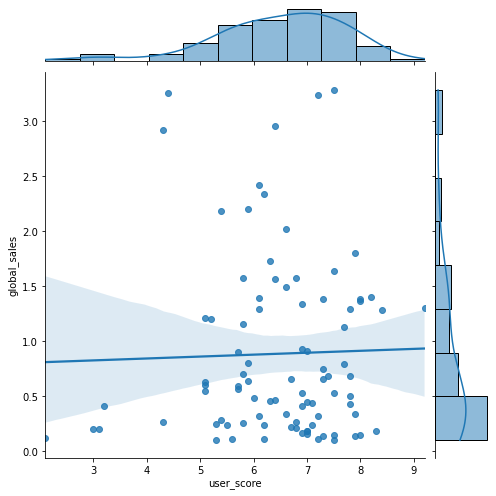

В более наглядном представлении XOne


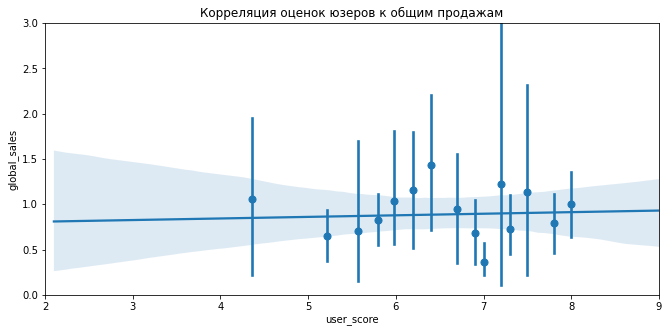

--------------------------------------------------------------

Построим диаграмму рассеивания продаж и оценок критиков XOne


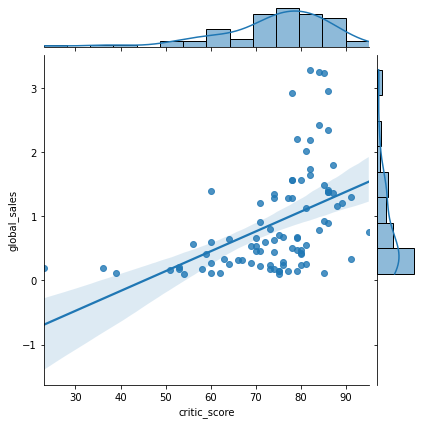

В более наглядном представлении XOne


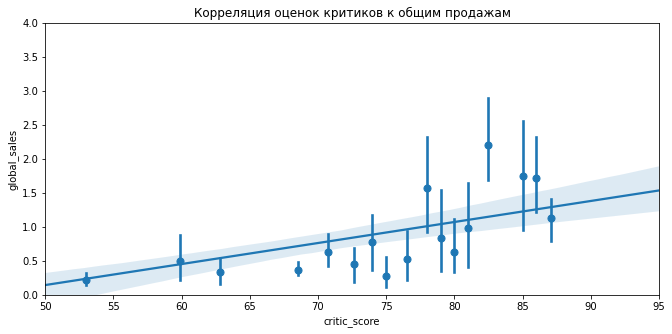

--------------------------------------------------------------


In [80]:
sns_plot_rel(XOne_score, 'XOne')

Тенденции на графиках для X Box очень похожи на тенденции PS4. Обратимся к коэффициантам корреляции.

In [81]:
#Рассчитаем коэффициент Пирсона оценок критиков и юзеров 
r = XOne_score['user_score'].corr(XOne_score['critic_score'])
print('Коэффициэнт Пирсона оценок критиков и юзеров равен :', '{:.2f}'.format(r))
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и юзеров равен : 0.51
Коэффициэнт Пирсона в 0.51 позволяет нам говорить о наличии заметной (по шкале Чеддока) положительной связи


In [82]:
#Рассчитаем коэффициент Пирсона оценок юзеров и общих продаж
r = XOne_score['user_score'].corr(XOne_score['global_sales'])
print('Коэффициэнт Пирсона оценок юзеров и общих продаж:', '{:.2f}'.format(r))    
power_coef_r(r)

Коэффициэнт Пирсона оценок юзеров и общих продаж: 0.03
Коэффициэнт Пирсона в 0.03 слишком мал мы не можем говорить о наличии какой-либо (по шкале Чеддока) связи


In [83]:
#Рассчитаем коэффициент Пирсона оценок критиков и общих продаж
r = XOne_score['critic_score'].corr(XOne_score['global_sales'])
print('Коэффициэнт Пирсона оценок критиков и общих продаж:', '{:.2f}'.format(r))    
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и общих продаж: 0.48
Коэффициэнт Пирсона в 0.48 позволяет нам говорить о наличии умеренной (по шкале Чеддока) положительной связи


И коэффициэнт корреляции говорит нам о схожих тенденциях X Box и PS4.

##### PC

In [84]:
#создадим нужную выборку
PC_score = score_platform('PC')

Посмотрим на распределения исследуемых признаков по платформе X Box one. 

--------------------------------------------------------------
Посмотрим сразу на все признаки платформы PC
--------------------------------------------------------------


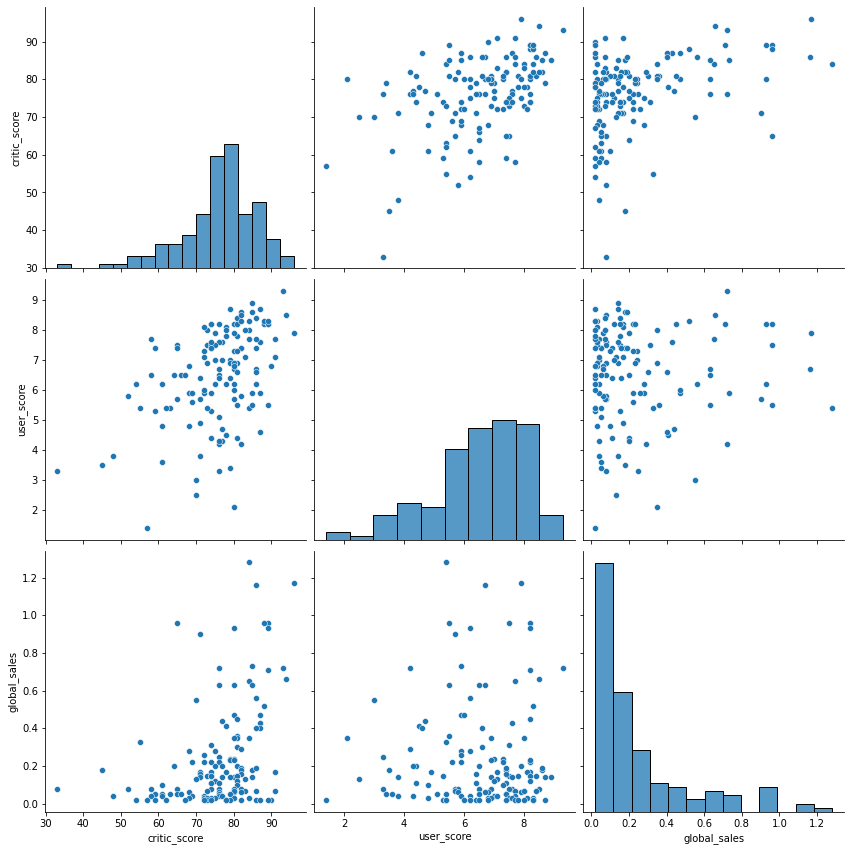

--------------------------------------------------------------

Взглянем на соотношение отзывов пользователей и критиков.


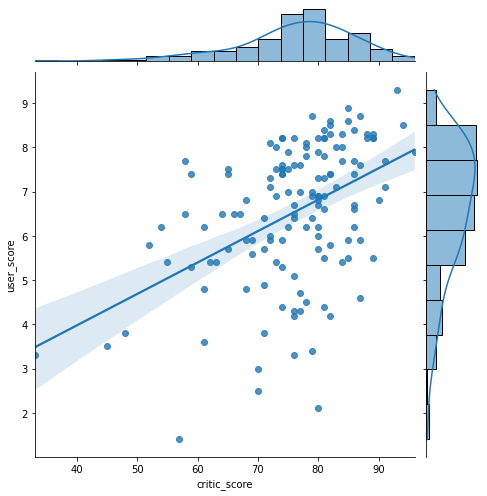

--------------------------------------------------------------

Построим диаграмму рассеивания продаж и оценок пользователей PC


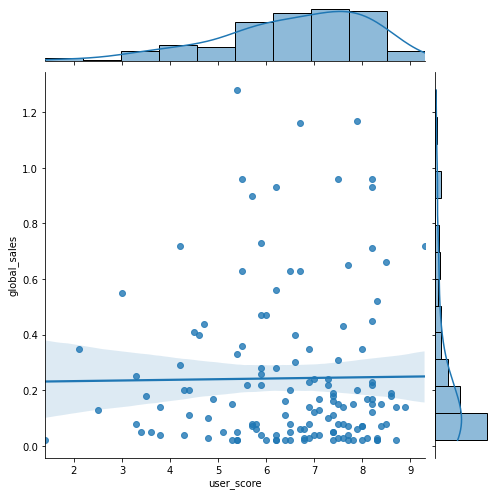

В более наглядном представлении PC


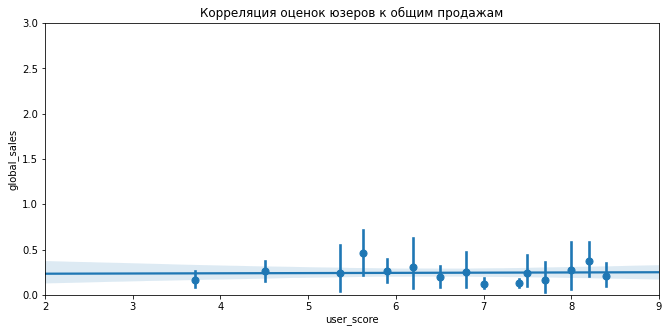

--------------------------------------------------------------

Построим диаграмму рассеивания продаж и оценок критиков PC


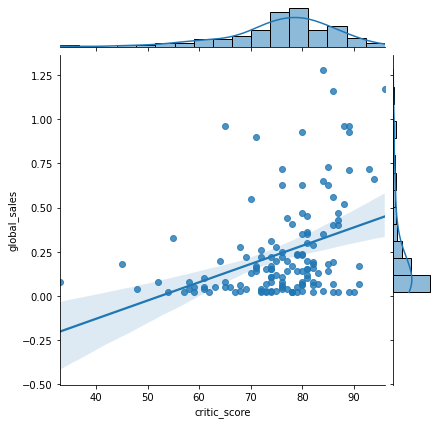

В более наглядном представлении PC


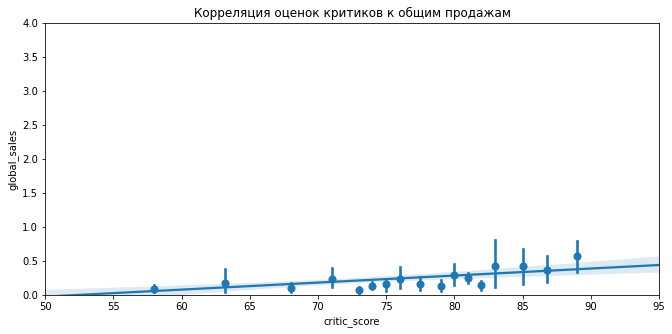

--------------------------------------------------------------


In [85]:
sns_plot_rel(PC_score, 'PC')

Тенденции на графиках для X Box очень похожи на ренденции PS4 и XBox. Обратимся к коэффициантам корреляции.

In [86]:
#Рассчитаем коэффициент Пирсона оценок критиков и юзеров 
r = PC_score['user_score'].corr(PC_score['critic_score'])
print('Коэффициэнт Пирсона оценок критиков и юзеров равен :', '{:.2f}'.format(r))
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и юзеров равен : 0.46
Коэффициэнт Пирсона в 0.46 позволяет нам говорить о наличии умеренной (по шкале Чеддока) положительной связи


In [87]:
#Рассчитаем коэффициент Пирсона оценок юзеров и общих продаж
r = PC_score['user_score'].corr(PC_score['global_sales'])
print('Коэффициэнт Пирсона оценок юзеров и общих продаж:', '{:.2f}'.format(r))    
power_coef_r(r)

Коэффициэнт Пирсона оценок юзеров и общих продаж: 0.01
Коэффициэнт Пирсона в 0.01 слишком мал мы не можем говорить о наличии какой-либо (по шкале Чеддока) связи


In [88]:
#Рассчитаем коэффициент Пирсона оценок критиков и общих продаж
r = PC_score['critic_score'].corr(PC_score['global_sales'])
print('Коэффициэнт Пирсона оценок критиков и общих продаж:', '{:.2f}'.format(r))    
power_coef_r(r)

Коэффициэнт Пирсона оценок критиков и общих продаж: 0.38
Коэффициэнт Пирсона в 0.38 позволяет нам говорить о наличии умеренной (по шкале Чеддока) положительной связи


И коэффициэнт корреляции говорит нам о схожих тенденциях X Box, PS4, PC.


#### Вывод

Для всех платформ выявлены схожие тенденции:
 - явная заметная (по шкале Чеддока) положительная связь оценок пользователей и критиков;
 - зависимость оценок пользователей и продаж или очень слабая или отсутствует;
 - сильная положительная связь оценок критиков и общих продаж.


### Зависимость продаж и жанров

Посмотрим на общее распределение игр по жанрам, чтобы ответить на вопросы о самых прибыльных жанрах, и выделяются ли жанры с высокими и низкими продажами.


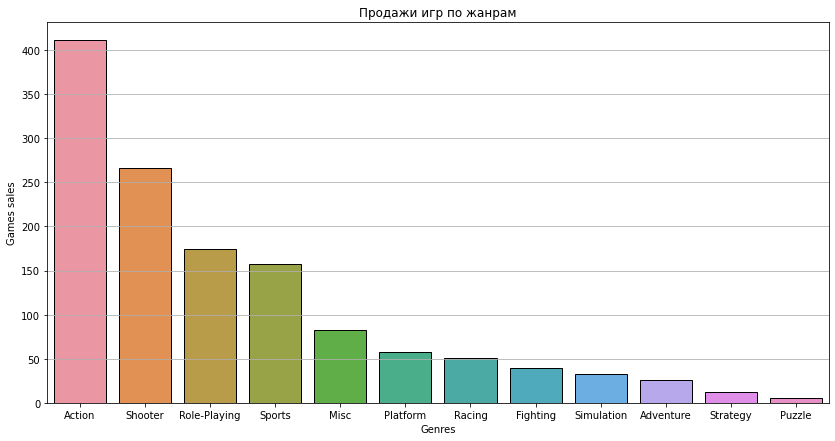

In [90]:
df_grouped = (
    actual_df
    .pivot_table(index='genre', values='global_sales', aggfunc='sum')
    .sort_values(by = 'global_sales', ascending = False)
)
df_grouped = df_grouped.reset_index(drop = False) 

plt.figure(figsize=(14,7))
sns.barplot(data=df_grouped, x='genre', y='global_sales', edgecolor="black")
plt.title("Продажи игр по жанрам")
plt.xlabel("Genres")
plt.ylabel("Games sales")
plt.grid(axis='y')
plt.show()

**Топ-4 жанров** по глобальным продажам - это **экшн, шутер, РПГ и спорт**. Последние позиции рейтинга занимают стратегии, приключения и пазл.

## Шаг 4. Портрет пользователя каждого региона

##### Создание функции, которая будет описывать пользователя для запрашиваемого региона

In [93]:
#Создадим функцию, которая будет описывать требуемый регион
def typical_user(col, region): #принимает на вход колонку с продажами в регионе и текстовое наименование региона
    # Обрежем нулевые значения продаж в регионе
    df = actual_df[actual_df[col] > 0]
    
    
    # Самые популярные платформы
    print('--------------------------------------------------------------')
    print('Продажи игр по платформам в регионе', region) #выводит поясняющий заголовок   
    df_grouped = ( #группируем платформы по суммарным значениям продаж в регионе
        df
        .pivot_table(index='platform', values=col, aggfunc='sum')
        .sort_values(by = col, ascending = False)
    )
    df_grouped = df_grouped.reset_index(drop = False) #переиндексируем группировку
    
    plt.figure(figsize=(16,8)) #зададим размер
    sns.barplot(data=df_grouped, x='platform', y=col, edgecolor="black") #строим столбчатую диаграмму
    plt.title("Продажи игр по платформам")#заголовок
    plt.xlabel("Platform")#ось Х
    plt.ylabel("Games sales")#ось У
    plt.grid(axis='y')
    plt.show()#показываем график
    
    
    # Самые популярные игры
    print('Продажи игр по жанрам в регионе', region)
    df_grouped = ( #группируем жанры по суммарным продажам
        df
        .pivot_table(index='genre', values=col, aggfunc='sum')
        .sort_values(by = col, ascending = False)
    )
    df_grouped = df_grouped.reset_index(drop = False) 
    
    plt.figure(figsize=(16,8))
    sns.barplot(data=df_grouped, x='genre', y=col, edgecolor="black")#строим столбчатую диаграмму
    plt.title("Продажи игр по жанрам в регионе")
    plt.xlabel("Genres")
    plt.ylabel("Games sales")
    plt.grid(axis='y')
    plt.show()#показываем график

    
    # Самые популярные платформы из перспективных
    print('--------------------------------------------------------------')
    print('Продажи игр по перспективным платформам в регионе', region)    
    df_grouped = (#группируем платформы из выбранных перспективных по суммарным продажам
        top_df
        .pivot_table(index='platform', values=col, aggfunc='sum')
        .sort_values(by = col, ascending = False)
    )
    df_grouped = df_grouped.reset_index(drop = False) 
    
    sns.barplot(data=df_grouped, x='platform', y=col, edgecolor="black")#строим столбчатую диаграмму
    plt.title("Продажи игр по перспективным платформам")
    plt.xlabel("Platform")
    plt.ylabel("Games sales")
    plt.show()#показываем график
    
    
    # Продажи для топ 5 платформ в долях процентов, от 100%
    # Сортируем платформы по сумме продаж по убыванию
    ratings = df.groupby('platform')[col].sum().sort_values(ascending = False)
    print('--------------------------------------------------------------')
    print('Продажи для топ 5 платформ в долях процентов в регионе', region)     
    labels=ratings[:5].index # выбираем только 5 топ платформ по индексам
    colors = ['tab:purple','tab:blue','tab:red','tab:cyan', 'tab:green'] #задаем цвета
    sizes = ratings[:5].values # выбираем только 5 топ платформ

    plt.figure(figsize = (9,9))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%')#строим круговую диаграмму
    plt.title('Наибольшая доля продаж для топ 5',fontsize = 15)
    plt.show()

    #Влияет ли рейтинг ESRB на продажи
    print('--------------------------------------------------------------')
    print('Влияние рейтинга ESRB на продажи для топ 5 в регионе', region)
    df_5 = df.query('platform in @labels')#срез по топ 5 платформ по сумме продаж
    f,ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(x=df_5.platform, y=df_5[col],hue=df_5.rating).set(ylim=(0, 2.4))#строим боксплот
    plt.show()


### Северо-американский пользователь

--------------------------------------------------------------
Продажи игр по платформам в регионе Северная америка


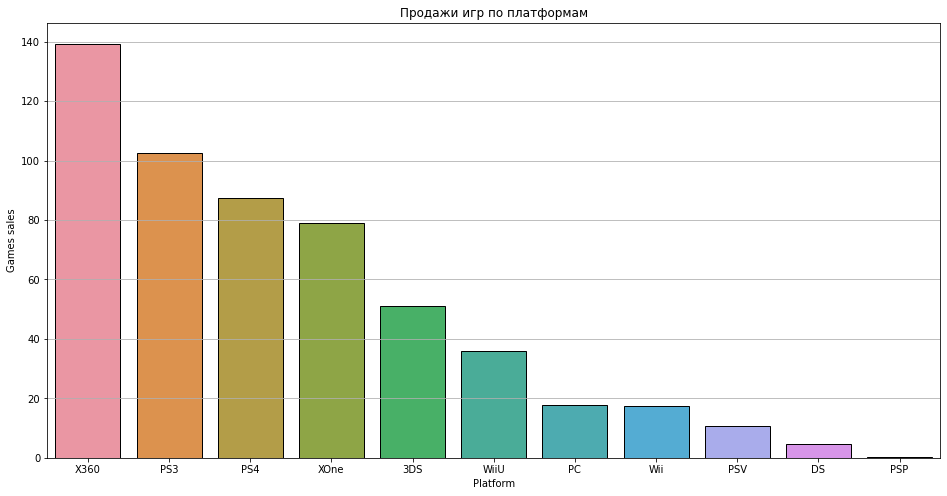

Продажи игр по жанрам в регионе Северная америка


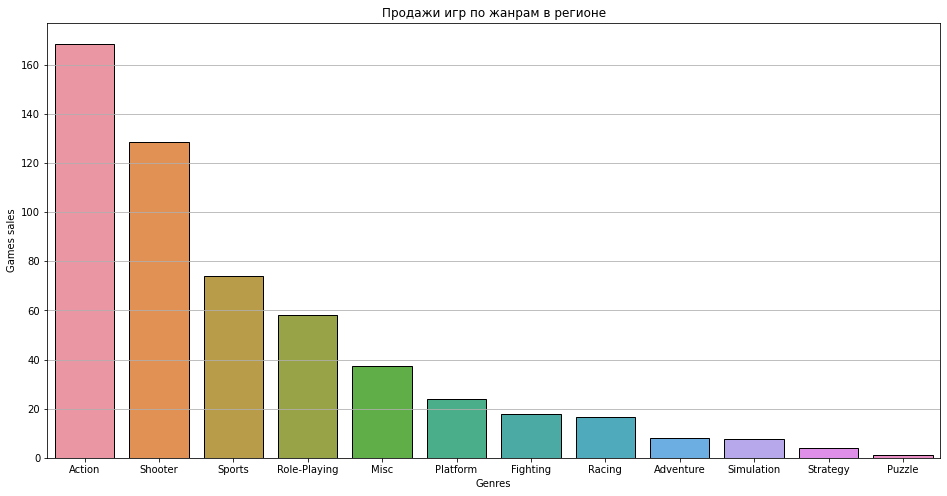

--------------------------------------------------------------
Продажи игр по перспективным платформам в регионе Северная америка


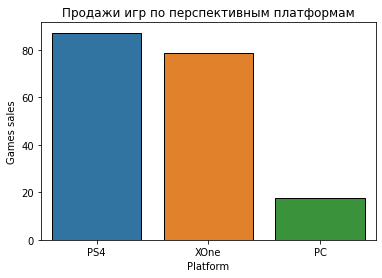

--------------------------------------------------------------
Продажи для топ 5 платформ в долях процентов в регионе Северная америка


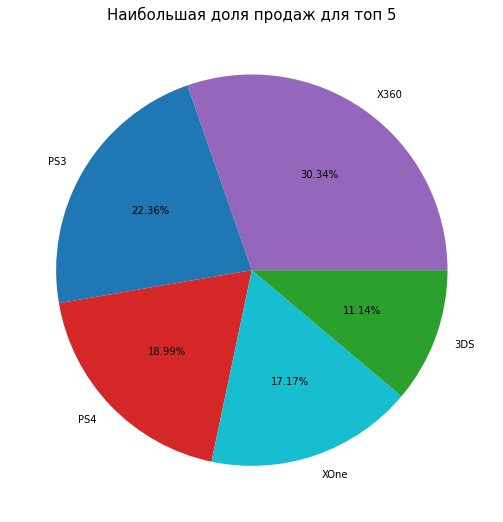

--------------------------------------------------------------
Влияние рейтинга ESRB на продажи для топ 5 в регионе Северная америка


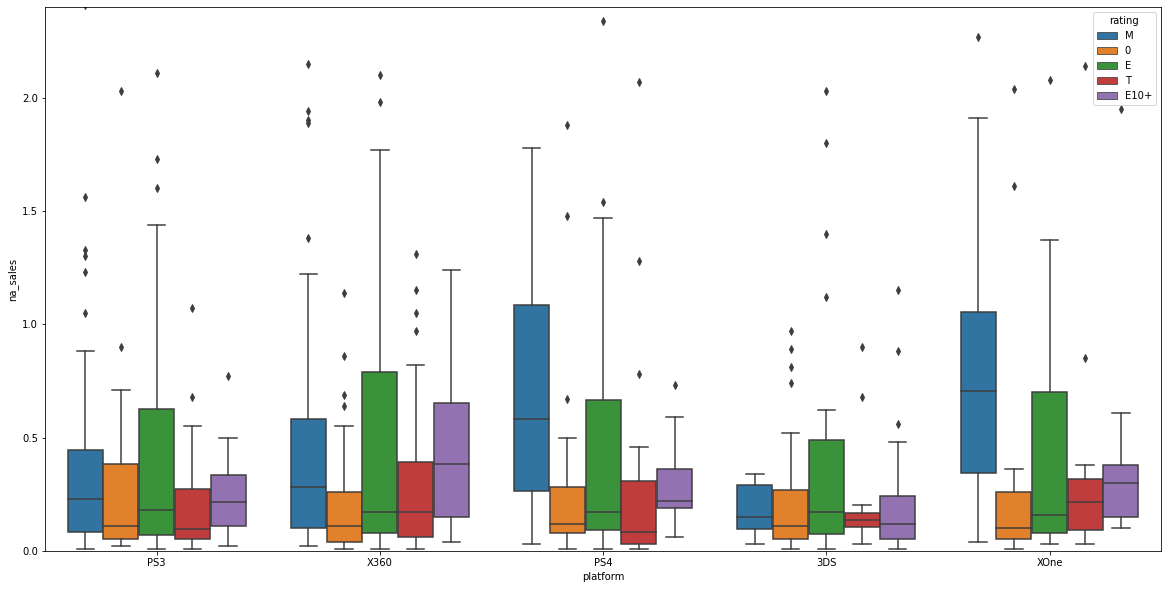

In [94]:
#вызовем нашу функцию для Северной Америки
typical_user('na_sales', 'Северная америка')

Для Северной Америки по продажам за последине 5 лет лидируют игры для XBox360 (**доля продаж 30.34%**), на втором месте PS3 (**доля продаж 22.36%**). Следующие два места в рейтинге занимают новые поколения этих же приставок, которые признаны нами перспективными - PS4 и XBoxOne (но тут первенство пока за PS4 (**доля продаж 18.99%** и **доля продаж 17.17%** соответственно)). Замыкает пятерку Nintendo3DS (**доля продаж 11.14%**).  Персональный компьютер занимает 7 место.

В жанрах на первых местах **Экшн и Шутер**, затем спортивный жанр и далее РПГ.

На графиках влияния рейтинга ESRB на продажи для топ 5 видно, что для **PS4 и XBoxOne** первенство достается рейтингу **«M» («Mature»)** — «От 17 лет», что легко объясняется, что новые версии игр для новых консолей выпускают, как правило крупные студии, которые ориентируются на более взрослую и состоятельную аудиторию. Со временем, когда консоль захватывает рынок и становится массовой выходит большое количество менее бюджетных игр и рассчитанных на категорию «E» («Everyone») — «Для всех», что мы видим по PS3 и XBox360.  У **Nintendo3DS** на первом месте игры с категорией **«E» («Everyone»)**, что объяснимо особенностеми консоли и её ориентированность на более широкий диапазон возрастов пользователей.

### Европейский пользователь

--------------------------------------------------------------
Продажи игр по платформам в регионе Европа


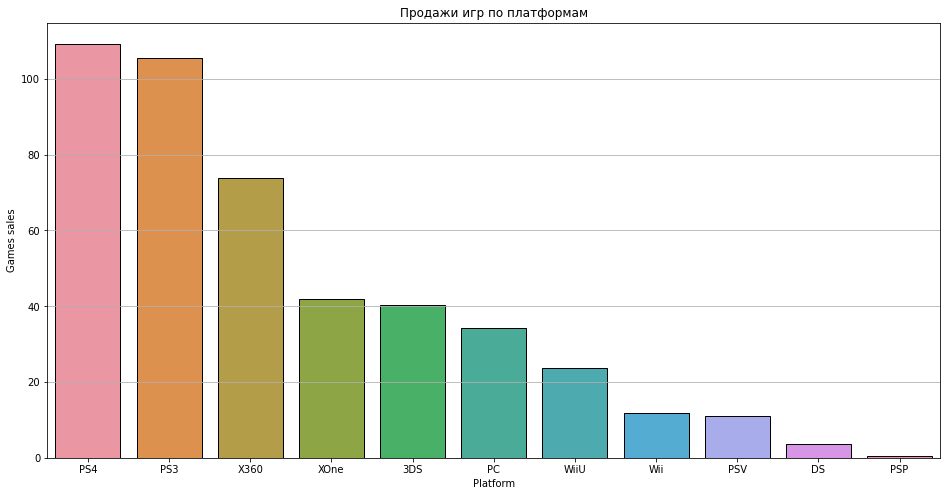

Продажи игр по жанрам в регионе Европа


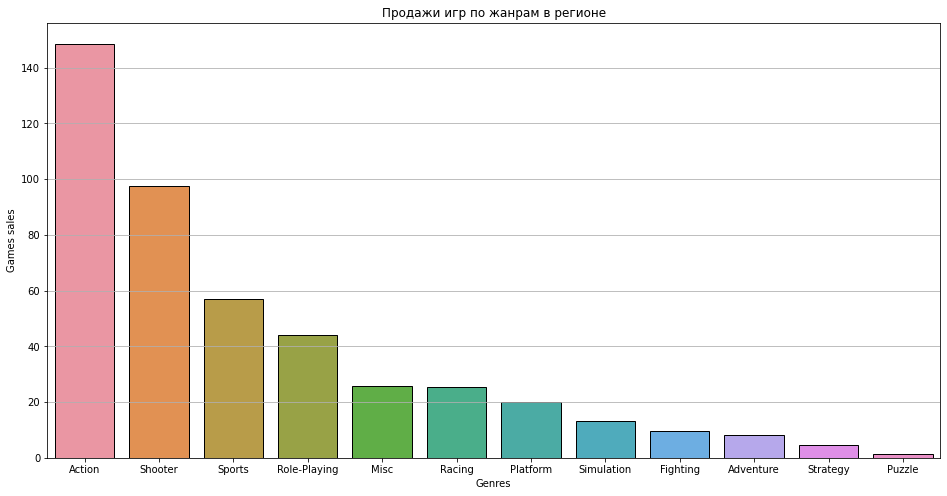

--------------------------------------------------------------
Продажи игр по перспективным платформам в регионе Европа


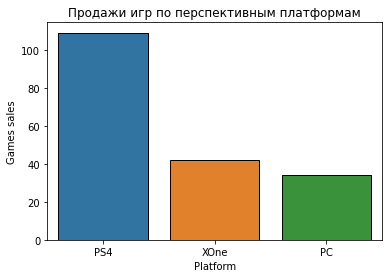

--------------------------------------------------------------
Продажи для топ 5 платформ в долях процентов в регионе Европа


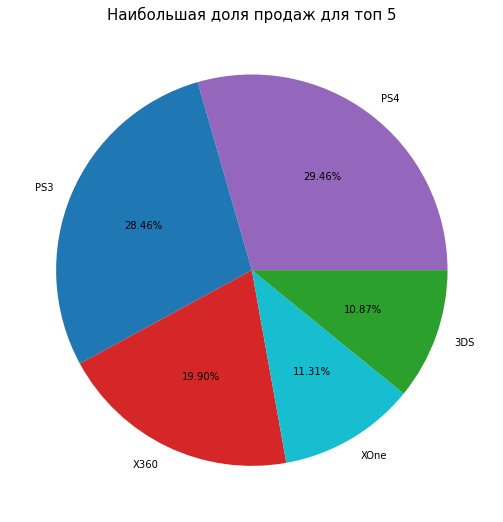

--------------------------------------------------------------
Влияние рейтинга ESRB на продажи для топ 5 в регионе Европа


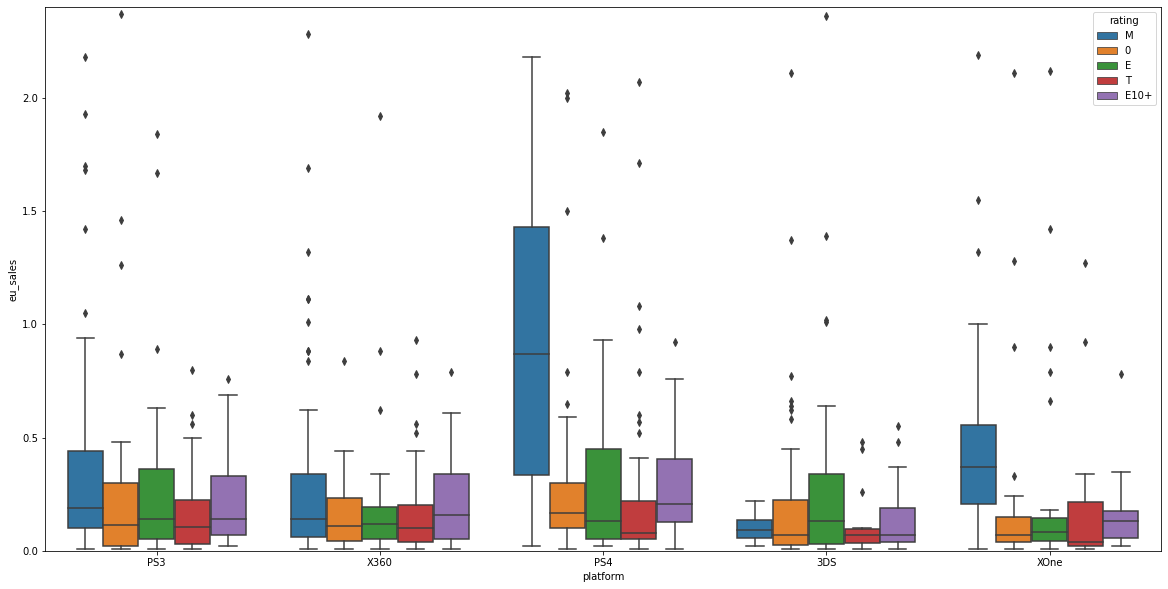

In [95]:
#вызовем нашу функцию для Европы
typical_user('eu_sales', 'Европа')

Для Европы по продажам на первом месте лидируют игры для PS4 (**доля продаж 29.46%**) и на втором месте PS3 (**доля продаж 28.46%**). Следующие два места в рейтинге исторические конкуренты - X360 и XBoxOne (но c отставанием от семейства PS (у XBox **доля продаж 19.90%** и **доля продаж 11.31%** соответственно)). Замыкает пятерку Nintendo3DS (**доля продаж 11.31**). Персональный компьютер занимает 6 место.

В жанрах на первых местах так же как и в северо-американском регионе **Экшн и Шутер**, затем спортивный жанр и далее РПГ.

На графиках влияния рейтинга ESRB на продажи для топ 5 видно, что для **PS4 и XBoxOne** абсолютное первенство достается рейтингу **«M» («Mature»)** — «От 17 лет». У предыдушего модельного ряда - PS3 и XBox360, также лидирует «M» («Mature»), но практически на равне с «E» («Everyone»)(у PS3) и «E10+» («Everyone 10 and older»)(у XBox360). У **Nintendo3DS** на первом месте игры с категорией **«E» («Everyone»)**.


### Японский пользователь

--------------------------------------------------------------
Продажи игр по платформам в регионе Япония


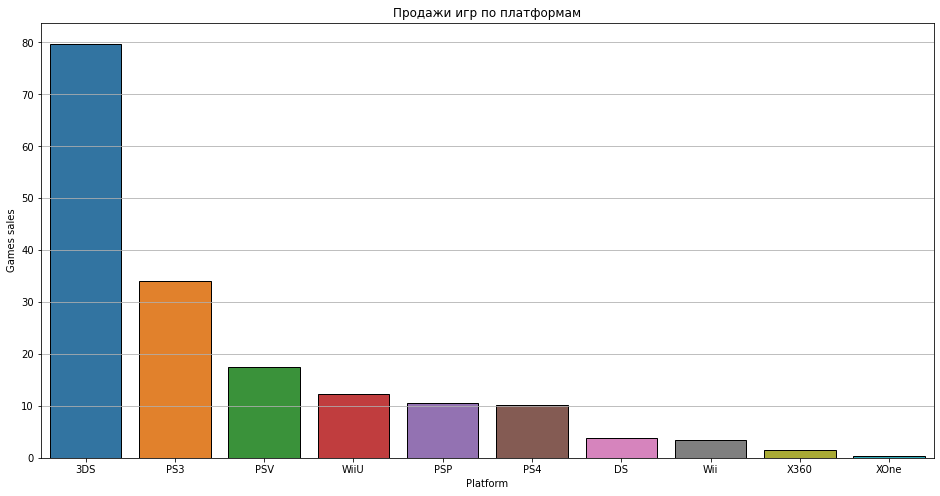

Продажи игр по жанрам в регионе Япония


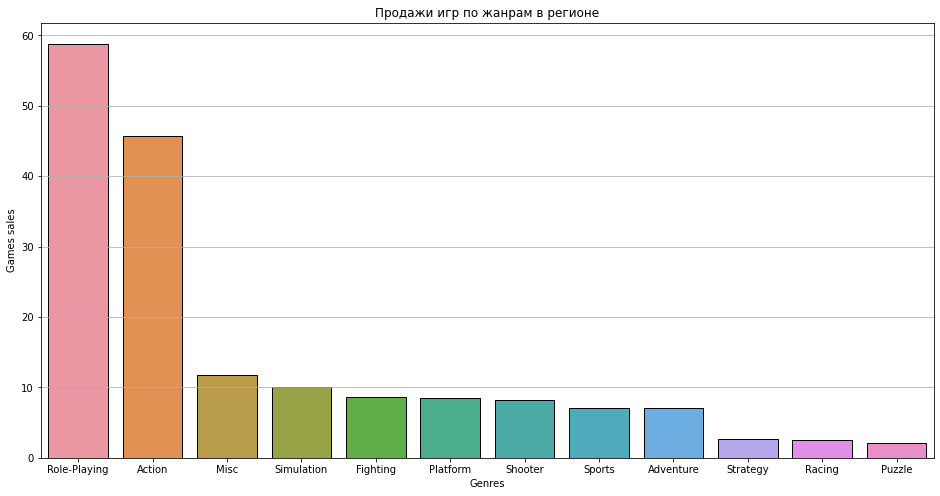

--------------------------------------------------------------
Продажи игр по перспективным платформам в регионе Япония


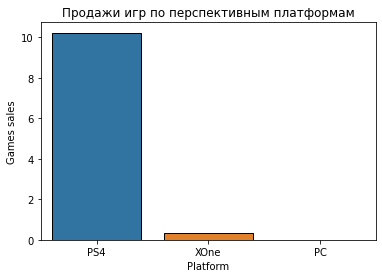

--------------------------------------------------------------
Продажи для топ 5 платформ в долях процентов в регионе Япония


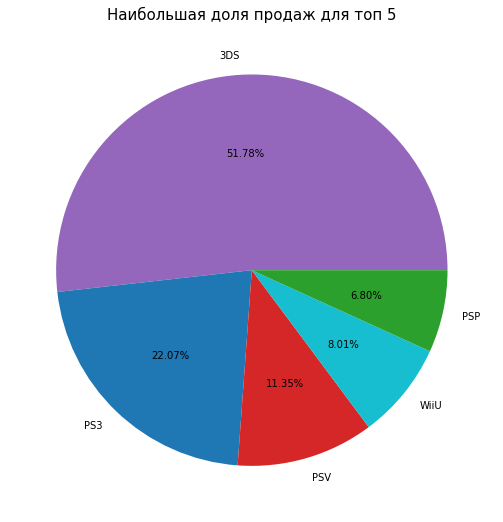

--------------------------------------------------------------
Влияние рейтинга ESRB на продажи для топ 5 в регионе Япония


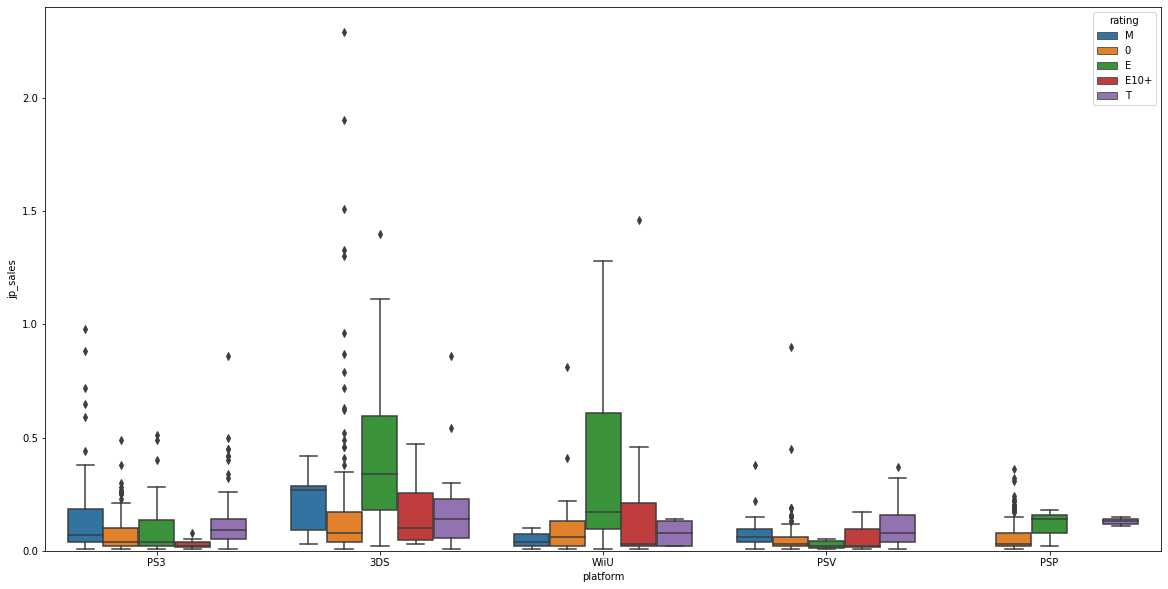

In [96]:
#вызовем нашу функцию для Японии
typical_user('jp_sales', 'Япония')

Японский игровой рынок кардинально отличается от северо-американского и европейского рынков.

Для Японии по продажам безоговорочно лидируют игры для национальной консоли Nintendo3DS (**доля продаж 51.78%**), на втором месте с существенным отрывом занимает PS3 **(доля продаж 22.07%)**. Семейство XBox занимет 9 и 10 места.  На третьем месте PlayStation Vita **(доля продаж 11.35%)**. На 4 и 5 местах Nintendo WiiU (**доля продаж 8.01%**) и PlayStation Portable **(доля продаж 6.80%)**. Персонального компьютера нет даже в топ10.

В жанрах на первом месте **РПГ**, на втором **Экшн**, при этом они наиболее популярны. А остальные жанры занимают примерно одинаковую нишу по продажам. На последних местах стратегии, гонки и пазл.

На графиках влияния рейтинга ESRB на продажи для топ 5 видно, что лидирует рейтинг **«E» («Everyone»)**. «T» («Teen») характерен для PSV. У PS3 первенство всё же достается достается рейтингу «M» («Mature»). 

## Шаг 5. Проверка гипотез

Перед нами поставлены следующие вопросы: 

    Одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC 
    Отличаются ли средние пользовательские рейтинги жанров Action и Sports 

### Одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC 

Для ответа на первый вопрос нам нужно проверить гипотезу о равенстве среднего двух генеральных совокупностей (все существующие в мире пользовательские рейтинги тарифов Xbox One и PC) по взятым из них выборкам (имеющиеся у нас рейтинги за актуальный период). Начнём с формулировки **нулевой гипотезы H₀ - «средние пользовательские рейтинги Xbox One и PC равны»**, соответственно **альтернативная гипотеза H₁ - «средние пользовательские рейтинги Xbox One и PC различаются»**.

In [99]:
#обрежем пустые пользовательские отзывы для PC
PC_user_score = actual_df[(actual_df['user_score'] > 0) & (actual_df['platform'] == 'PC')]

#обрежем пустые пользовательские отзывы для PC
XOne_user_score = actual_df[(actual_df['user_score'] > 0) & (actual_df['platform'] == 'XOne')]

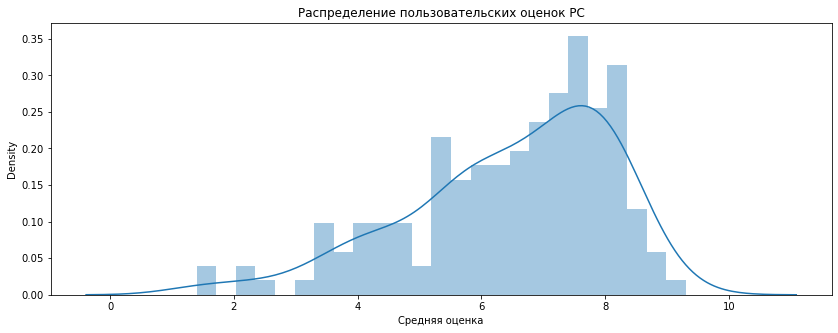

In [130]:
#визуализируем распределение выборки для оценки нормальности
plt.figure(figsize=(14, 5))
sns.distplot(PC_user_score['user_score'], bins=25)
plt.title('Распределение пользовательских оценок PC')
plt.xlabel('Средняя оценка')
plt.show()

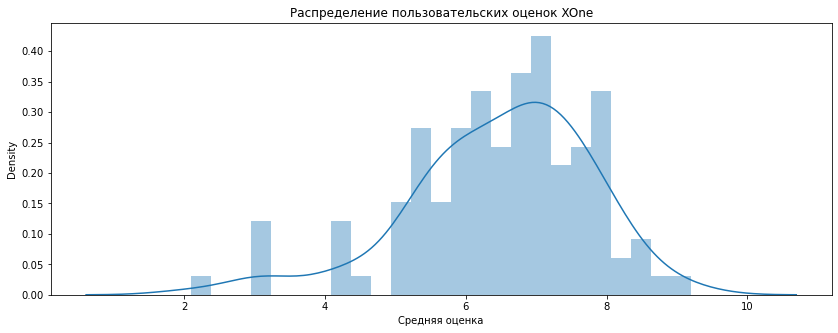

In [129]:
#визуализируем распределение выборки для оценки нормальности
plt.figure(figsize=(14, 5))
sns.distplot(XOne_user_score['user_score'], bins=25)
plt.title('Распределение пользовательских оценок XOne')
plt.xlabel('Средняя оценка')
plt.show()

In [105]:
#вычислим дисперсию выборок для корректного определения атрибута equal_val в Т–тесте
print(PC_user_score['user_score'].var(ddof=1))
print(XOne_user_score['user_score'].var(ddof=1))

2.7109079360961914
1.6594934463500977


Так как мы имеем ограниченный набор статистических данных для анализа, то распределение соответствующее нашим гипотезам будет являться распределением Стьюдента (t-распределением). Поэтому в качестве статистического теста для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам будем использовать t-тест - метод `scipy.stats.ttest_ind()`. Условия для Т-теста соблюдены, количество наблюдений больше 30, распределение выборок приближено к нормальному. Проверка дисперсий указывает нам, что в Т-тесте атрибут `equal_val` определим как False. 

In [127]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind( #t тест Стьюдента
    PC_user_score['user_score'], 
    XOne_user_score['user_score'],
    equal_var = False)

print("Медиана отзывов пользователей для игр на PC", PC_user_score['user_score'].median())#покажем медиану для наглядности
print("Медиана отзывов пользователей для игр на XBoxOne", XOne_user_score['user_score'].median())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, следовательно средние пользовательские рейтинги XboxOne и PC различаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, следовательно средние пользовательские рейтинги Xbox One и PC равны") 

Медиана отзывов пользователей для игр на PC 6.800000190734863
Медиана отзывов пользователей для игр на XBoxOne 6.699999809265137
p-значение: 0.9441779482780174
Не получилось отвергнуть нулевую гипотезу, следовательно средние пользовательские рейтинги Xbox One и PC равны


#### Вывод

Полученное значение p-value говорит о том (если р-уровень больше или равно 0.05, то мы считаем, что средние значения в группах статистически не отличаются), что хотя средняя отзывы пользователей хоть немного и отличаются, но с вероятностью в **94%** такое или большее **различие можно получить случайно**. Это явно слишком большая вероятность, чтобы делать вывод о различии между значениями средних рейтингов. 

### Отличаются ли средние пользовательские рейтинги жанров Action и Sports 

Для ответа на данный вопрос нам нужно проверить гипотезу о равенстве среднего двух генеральных совокупностей (все существующие в мире пользовательские рейтинги жанров Action и Sports ) по взятым из них выборкам (имеющиеся у нас рейтинги за актуальный период). Начнём с формулировки **нулевой гипотезы H₀ - «средние пользовательские рейтинги жанров Action и Sports равны»**, соответственно **альтернативная гипотеза H₁ - «средние пользовательские рейтинги жанров Action и Sports различаются»**.

In [128]:
#обрежем пустые пользовательские отзывы для Action
Action_user_score = actual_df[(actual_df['user_score'] > 0) & (actual_df['genre'] == 'Action')]

#обрежем пустые пользовательские отзывы для Sports
Sports_user_score = actual_df[(actual_df['user_score'] > 0) & (actual_df['genre'] == 'Sports')]

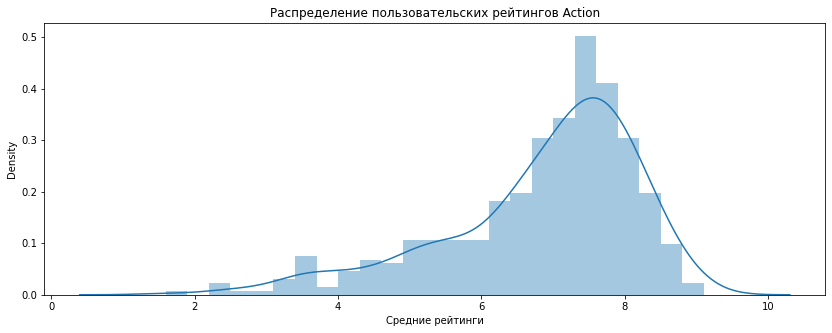

In [131]:
#визуализируем распределение выборки для оценки нормальности
plt.figure(figsize=(14, 5))
sns.distplot(Action_user_score['user_score'], bins=25)
plt.title('Распределение пользовательских рейтингов Action')
plt.xlabel('Средние рейтинги')
plt.show()

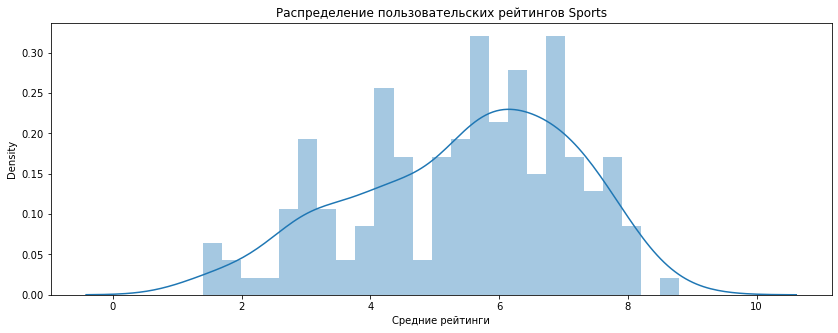

In [132]:
#визуализируем распределение выборки для оценки нормальности
plt.figure(figsize=(14, 5))
sns.distplot(Sports_user_score['user_score'], bins=25)
plt.title('Распределение пользовательских рейтингов Sports')
plt.xlabel('Средние рейтинги')
plt.show()

In [133]:
#вычислим дисперсию выборок для корректного определения атрибута equal_val в Т–тесте
print(Action_user_score['user_score'].var(ddof=1))
print(Sports_user_score['user_score'].var(ddof=1))

1.8318084478378296
2.7803475856781006


Так как мы имеем ограниченный набор статистических данных для анализа, то распределение соответствующее нашим гипотезам будет являться распределением Стьюдента (t-распределением). Поэтому в качестве статистического теста для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам будем использовать t-тест - метод `scipy.stats.ttest_ind()`. Условия для Т-теста соблюдены, количество наблюдений больше 30, распределение выборок приближено к нормальному. Проверка дисперсий указывает нам, что в Т-тесте атрибут `equal_val` определим как False (значение атрибута метода по умолчанию). 

In [134]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind( #t тест Стьюдента
    Action_user_score['user_score'], 
    Sports_user_score['user_score'])

print("Медиана отзывов пользователей для игр жанра Action", Action_user_score['user_score'].median())#покажем медиану для наглядности
print("Медиана отзывов пользователей для игр жанра Sports", Sports_user_score['user_score'].median())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, следовательно средние пользовательские рейтинги жанров Action и Sports различаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, следовательно средние пользовательские рейтинги жанров Action и Sports равны") 

Медиана отзывов пользователей для игр жанра Action 7.199999809265137
Медиана отзывов пользователей для игр жанра Sports 5.699999809265137
p-значение: 1.3744918846417065e-23
Отвергаем нулевую гипотезу, следовательно средние пользовательские рейтинги жанров Action и Sports различаются


#### Вывод

Полученное значение p-value 1.3 × 10^(−23) **черезвычайно мало** и говорит о том, что средняя рейтинги неодинаковы, и получить такое различие случайно крайне маловероятно. Это явно слишком маленькая вероятность, можно делать вывод о **значимом различии** средних рейтингов жанров Action и Sports.

## Шаг 6. Общий вывод

Как мы увидели подход к рынкам в разных регионах должен отличаться, поэтому сформируем прогноз для каждого региона в отдельности.

Для рынка **Северной Америки** выявлены следующие тенденции:
     
    наиболее перспективны PS4 и XBoxOne, причем линейка XBox исторически опережала PS;
    перспективные жанры Экшн, Шутер, затем спортивный жанр и РПГ;
    продажи игр для PC исторически показывают невысокую, но стабильную прибыль;
    
Для рынка **Европы** выявлены следующие тенденции:    

    наиболее перспективна PS4, линейка XBox отстает по продажам от PS(но занимает вторые места);
    перспективные жанры Экшн, Шутер, затем спортивный жанр и РПГ;
    продажи игр для PC исторически показывают невысокую, но стабильную прибыль;

Для рынка **Японии** выявлены следующие тенденции:    

    до сих пор остается перспективной Nintendo3DS и PS3. В дальнейшем следует обратить внимание на PS4;
    линейка XBox НЕ популярна;
    перспективные жанры РПГ, затем Экшн.Остальные жанры занимают относительно одинаковую нишу по продажам;
    низкие значения продаж игр для PC.
    лидирует рейтинг «Everyone»

**Общие** тенденции: 

    продажи игр по приставкам PS3, XBox360 идут на убыль
    для PS4 и XBoxOne первое время будут перспективны игры с рейтингом «Mature», затем «Everyone»
    явная заметная (по шкале Чеддока) положительная связь оценок пользователей и критиков;
    зависимость оценок пользователей и продаж или очень слабая или отсутствует;
    сильная положительная связь оценок критиков и общих продаж.
    
Проверены **гипотезы**:
    
    средние пользовательские рейтинги Xbox One и PC равны
    средние пользовательские рейтинги жанров Action и Sports различаются
    
P.S. Также с учётом стабильности доходов по PC будет разумно обратить внимание и на эту платформу. Принимая во внимание масштабы цифрового "пиратства" наиболее выгодным представляется развивать цифровую дистрибьюцию игр, которые нивелируют возможность её пиратского распространения, например многопользовательские игры, или игры, предоставляемые по подписке, или же продавать внутриигровые предметы (если это конечно же не запрещается соглашением пользователя). 

---